In [6]:
import math
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode            # What you'd normally run
#from learntools.geospatial.tools import geocode # Just for this exercise

import folium 
from folium import Marker
from folium.plugins import MarkerCluster

# from learntools.core import binder
# binder.bind(globals())
# from learntools.geospatial.ex4 import *

In [40]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


import folium # plotting library



In [7]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## Load the data of the starbucks store locations

In [8]:
# Load and preview Starbucks locations in California
starbucks = pd.read_csv("full_starbucks.csv")
starbucks.head()

,Unnamed: 0,Store Number,Store Name,Address,City,Longitude,Latitude,geometry
0,0,10429-100710,Palmdale & Hwy 395,14136 US Hwy 395 Adelanto CA,Adelanto,-117.40,34.51,POINT (-117.4 34.51)
1,1,635-352,Kanan & Thousand Oaks,5827 Kanan Road Agoura CA,Agoura,-118.76,34.16,POINT (-118.76 34.16)
2,2,74510-27669,Vons-Agoura Hills #2001,5671 Kanan Rd. Agoura Hills CA,Agoura Hills,-118.76,34.15,POINT (-118.76 34.15)
3,3,29839-255026,Target Anaheim T-0677,8148 E SANTA ANA CANYON ROAD AHAHEIM CA,AHAHEIM,-117.75,33.87,POINT (-117.75 33.87)
4,4,23463-230284,Safeway - Alameda 3281,2600 5th Street Alameda CA,Alameda,-122.28,37.79,POINT (-122.28 37.79)


To Check if there is any missing value

In [9]:

import numpy as np
print(starbucks.isnull().sum())



Unnamed: 0      0
Store Number    0
Store Name      0
Address         0
City            0
Longitude       0
Latitude        0
geometry        0
dtype: int64


Considering only the five locations in Berkeley, how many of the (latitude, longitude) locations seem potentially correct (are located in the correct city)?

###  Consolidate the data.


In [10]:
CA_counties = gpd.read_file("CA_counties.shp")
CA_counties.head()

,GEOID,name,area_sqkm,geometry
0,6091,Sierra County,2491.995494,"POLYGON ((-120.65560 39.69357, -120.65554 39.6..."
1,6067,Sacramento County,2575.258262,"POLYGON ((-121.18858 38.71431, -121.18732 38.7..."
2,6083,Santa Barbara County,9813.817958,"MULTIPOLYGON (((-120.58191 34.09856, -120.5822..."
3,6009,Calaveras County,2685.626726,"POLYGON ((-120.63095 38.34111, -120.63058 38.3..."
4,6111,Ventura County,5719.321379,"MULTIPOLYGON (((-119.63631 33.27304, -119.6360..."


Next, we create three DataFrames:
- `CA_pop` contains an estimate of the population of each county.
- `CA_high_earners` contains the number of households with an income of at least $150,000 per year.
- `CA_median_age` contains the median age for each county.

In [11]:
CA_pop = pd.read_csv("datasets_348259_695175_CA_county_population.csv", index_col="GEOID")
CA_high_earners = pd.read_csv("datasets_348259_695175_CA_county_high_earners.csv", index_col="GEOID")
CA_median_age = pd.read_csv("datasets_348259_695175_CA_county_median_age.csv", index_col="GEOID")
CA_pop.head()

,population
GEOID,
6001,1666753
6003,1101
6005,39383
6007,231256
6009,45602


In [12]:

cols_to_add =  CA_pop.join([CA_high_earners, CA_median_age]).reset_index()
CA_stats = CA_counties.merge(cols_to_add, on="GEOID")



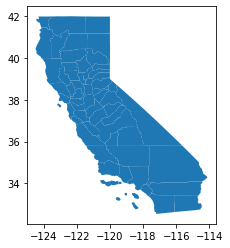

In [13]:
CA_stats.head()
CA_stats.plot()

In [14]:
CA_stats["density"] = CA_stats["population"] / CA_stats["area_sqkm"]

 Which counties look promising?


- there are at least 100,000 households making \$150,000 per year,
- the median age is less than 38.5, and
- the density of inhabitants is at least 285 (per square kilometer).

Additionally, selected counties should satisfy at least one of the following criteria:
- there are at least 500,000 households making \$150,000 per year,
- the median age is less than 35.5, or
- the density of inhabitants is at least 1400 (per square kilometer).

In [15]:

sel_counties = CA_stats.loc[((CA_stats["high_earners"]>=100000)&(CA_stats["median_age"]<=38.5)&(CA_stats["density"] >=285))&\
                            ((CA_stats['high_earners']>=500000)|(CA_stats["median_age"]<35.5)|(CA_stats["density"]>1400))]


### 5) How many stores did you identify?

When looking for the next Starbucks Reserve Roastery location, you'd like to consider all of the stores within the counties that you selected.  So, how many stores are within the selected counties?

To prepare to answer this question, run the next code cell to create a GeoDataFrame `starbucks_gdf` with all of the starbucks locations.

In [16]:
print(sel_counties)

    GEOID                  name     area_sqkm  \
5    6037    Los Angeles County  12305.376879   
8    6073      San Diego County  11721.342229   
10   6075  San Francisco County    600.588247   

                                             geometry  population  \
5   MULTIPOLYGON (((-118.66761 33.47749, -118.6682...    10105518   
8   POLYGON ((-117.43744 33.17953, -117.44955 33.1...     3343364   
10  MULTIPOLYGON (((-122.60025 37.80249, -122.6123...      883305   

    high_earners  median_age      density  
5         501413        36.0   821.227834  
8         194676        35.4   285.237299  
10        114989        38.3  1470.733077  


,Unnamed: 0,Store Number,Store Name,Address,City,Longitude,Latitude,geometry
0,0,10429-100710,Palmdale & Hwy 395,14136 US Hwy 395 Adelanto CA,Adelanto,-117.40,34.51,POINT (-117.40000 34.51000)
1,1,635-352,Kanan & Thousand Oaks,5827 Kanan Road Agoura CA,Agoura,-118.76,34.16,POINT (-118.76000 34.16000)
2,2,74510-27669,Vons-Agoura Hills #2001,5671 Kanan Rd. Agoura Hills CA,Agoura Hills,-118.76,34.15,POINT (-118.76000 34.15000)
3,3,29839-255026,Target Anaheim T-0677,8148 E SANTA ANA CANYON ROAD AHAHEIM CA,AHAHEIM,-117.75,33.87,POINT (-117.75000 33.87000)
4,4,23463-230284,Safeway - Alameda 3281,2600 5th Street Alameda CA,Alameda,-122.28,37.79,POINT (-122.28000 37.79000)


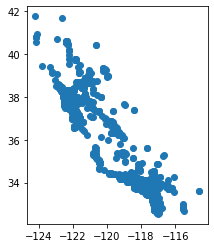

In [17]:
starbucks_gdf = gpd.GeoDataFrame(starbucks, geometry=gpd.points_from_xy(starbucks.Longitude, starbucks.Latitude))

starbucks_gdf.crs = 'epsg:4326'
starbucks_gdf.plot()
starbucks_gdf.head()

So, how many stores are in the counties you selected?

In [18]:
locations_of_interest = gpd.sjoin(starbucks_gdf, sel_counties)
num_stores = len(locations_of_interest)


print(len(gpd.sjoin(sel_counties, starbucks_gdf)))

1043


### Visualize the store locations.

Create a map that shows the locations of the stores that you identified in the previous question.

In [69]:
gpd.sjoin(sel_counties, starbucks_gdf).sort_values(by=["population","high_earners"], ascending=False).head()

,GEOID,name,area_sqkm,geometry,population,high_earners,median_age,density,index_right,Unnamed: 0,Store Number,Store Name,Address,City,Longitude,Latitude
5,6037,Los Angeles County,12305.376879,"MULTIPOLYGON (((-118.66761 33.47749, -118.6682...",10105518,501413,36.0,821.227834,2282,2282,5694-5504,Western & 25th,"2470 S Western Ave, Fifth Gaffey Plaza San Ped...",San Pedro,-118.31,33.72
5,6037,Los Angeles County,12305.376879,"MULTIPOLYGON (((-118.66761 33.47749, -118.6682...",10105518,501413,36.0,821.227834,2285,2285,74609-90934,Vons-San Pedro #2162,1440 W 25th St San Pedro CA,San Pedro,-118.31,33.72
5,6037,Los Angeles County,12305.376879,"MULTIPOLYGON (((-118.66761 33.47749, -118.6682...",10105518,501413,36.0,821.227834,2284,2284,79519-103403,Vons - San Pedro #2283,1221 S. GAFFEY Street San Pedro CA,San Pedro,-118.29,33.74
5,6037,Los Angeles County,12305.376879,"MULTIPOLYGON (((-118.66761 33.47749, -118.6682...",10105518,501413,36.0,821.227834,2283,2283,11868-105618,"Gaffey & 5th, San Pedro",438 S. Gaffey Ave San Pedro CA,San Pedro,-118.29,33.74
5,6037,Los Angeles County,12305.376879,"MULTIPOLYGON (((-118.66761 33.47749, -118.6682...",10105518,501413,36.0,821.227834,1679,1679,6926-88400,Palos Verdes Dr. West & Hawthorne,"31202 Palos Verdes Dr. West, Las Flores Rancho...",Rancho Palos Verdes,-118.41,33.75


In [70]:

m_6 = folium.Map(location=[37,-120], zoom_start=6)

mc = MarkerCluster()
locations_of_interest = gpd.sjoin(starbucks_gdf, sel_counties)
# Your code here: show selected store locations
for idx, row in locations_of_interest.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(folium.Marker([row['Latitude'], row['Longitude']]))

m_6.add_child(mc)

# Show the map
embed_map(m_6, 'q_6.html')

### The choice is narrowed down to LA and San Diego

In [35]:
# @hidden_cell 
CLIENT_ID = 'D3FCSLQC3JIEXLXNJ5GARE3EH3KMBSCLEIEY1BOPINDTBIFJ'
CLIENT_SECRET = 'CRO2NMINVUX04BZKSNSHWUQQI4S04OADJYVDKXIMZ5CA5EBC'
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [71]:
address_1 = gpd.sjoin(sel_counties, starbucks_gdf).sort_values(by=["density","high_earners"], ascending=False).iloc[0,-4]
address_1

'3251 20th Ave, Ste 250F San Francisco CA'

In [73]:
latitude = gpd.sjoin(sel_counties, starbucks_gdf).sort_values(by=["density","high_earners"], ascending=False).iloc[0,-1]
longitude = gpd.sjoin(sel_counties, starbucks_gdf).sort_values(by=["density","high_earners"], ascending=False).iloc[0,-2]
print(latitude, longitude)

37.73 -122.48


In [74]:
search_query = 'Coffee'
radius = 500

In [75]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=D3FCSLQC3JIEXLXNJ5GARE3EH3KMBSCLEIEY1BOPINDTBIFJ&client_secret=CRO2NMINVUX04BZKSNSHWUQQI4S04OADJYVDKXIMZ5CA5EBC&ll=37.73,-122.48&v=20180605&query=Coffee&radius=500&limit=100'

In [76]:
results_1 = requests.get(url).json()


In [77]:
# assign relevant part of JSON to venues
venues = results_1['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

c:\users\peng\pycharmprojects\base_evnv\venv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.city,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,5227b1b08bfdf21a788fc5a0,Peet's Coffee & Tea,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1598041750,False,"3251 20th Avenue, Suite P182,",inside Stonestown Galleria,37.727715,-122.476555,"[{'label': 'display', 'lat': 37.727715, 'lng':...",...,San Francisco,CA,United States,"[3251 20th Avenue, Suite P182, (inside Stonest...",1831924,https://www.grubhub.com/restaurant/peets-coffe...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png
1,5c69a2c586f4cc002c436543,Red Whale Coffee,"[{'id': '56aa371be4b08b9a8d57350b', 'name': 'F...",v-1598041750,False,NaN,NaN,37.730068,-122.479090,"[{'label': 'display', 'lat': 37.730068, 'lng':...",...,San Francisco,CA,United States,"[San Francisco, CA 94132, United States]",NaN,NaN,NaN,NaN,NaN,NaN
2,4a45130cf964a520bca71fe3,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1598041750,False,3251 20th Ave,at Stonestown Galleria,37.727959,-122.476803,"[{'label': 'display', 'lat': 37.72795856, 'lng...",...,San Francisco,CA,United States,"[3251 20th Ave (at Stonestown Galleria), San F...",NaN,NaN,NaN,NaN,NaN,NaN


### A. Let's explore the Peet's Coffee

In [78]:
venue_id = '5227b1b08bfdf21a788fc5a0' # ID 
url_id1 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url_id1

'https://api.foursquare.com/v2/venues/5227b1b08bfdf21a788fc5a0?client_id=D3FCSLQC3JIEXLXNJ5GARE3EH3KMBSCLEIEY1BOPINDTBIFJ&client_secret=CRO2NMINVUX04BZKSNSHWUQQI4S04OADJYVDKXIMZ5CA5EBC&v=20180605'

In [79]:
result_id1 = requests.get(url_id1).json()
print(result_id1['response']['venue'].keys())
result_id1['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'delivery', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'parent', 'hierarchy', 'attributes', 'bestPhoto', 'colors'])


{'id': '5227b1b08bfdf21a788fc5a0',
 'name': "Peet's Coffee & Tea",
 'contact': {'phone': '4152138380',
  'formattedPhone': '(415) 213-8380',
  'twitter': 'peets_tweets'},
 'location': {'address': '3251 20th Avenue, Suite P182,',
  'crossStreet': 'inside Stonestown Galleria',
  'lat': 37.727715,
  'lng': -122.476555,
  'labeledLatLngs': [{'label': 'display',
    'lat': 37.727715,
    'lng': -122.476555},
   {'label': 'entrance', 'lat': 37.727831, 'lng': -122.47649}],
  'postalCode': '94132',
  'cc': 'US',
  'city': 'San Francisco',
  'state': 'CA',
  'country': 'United States',
  'formattedAddress': ['3251 20th Avenue, Suite P182, (inside Stonestown Galleria)',
   'San Francisco, CA 94132',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/peets-coffee--tea/5227b1b08bfdf21a788fc5a0',
 'categories': [{'id': '4bf58dd8d48988d1e0931735',
   'name': 'Coffee Shop',
   'pluralName': 'Coffee Shops',
   'shortName': 'Coffee Shop',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

### B. Get the venue's overall rating

In [80]:
try:
    print(result_id1['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.0


### C. Let's explore the Red Whale Coffee

In [81]:
venue_id_2 = '5c69a2c586f4cc002c436543' # I
url_id2 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url_id2

'https://api.foursquare.com/v2/venues/5227b1b08bfdf21a788fc5a0?client_id=D3FCSLQC3JIEXLXNJ5GARE3EH3KMBSCLEIEY1BOPINDTBIFJ&client_secret=CRO2NMINVUX04BZKSNSHWUQQI4S04OADJYVDKXIMZ5CA5EBC&v=20180605'

In [82]:
result_id2 = requests.get(url_id2).json()
print(result_id2['response']['venue'].keys())
result_id2['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'delivery', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'parent', 'hierarchy', 'attributes', 'bestPhoto', 'colors'])


{'id': '5227b1b08bfdf21a788fc5a0',
 'name': "Peet's Coffee & Tea",
 'contact': {'phone': '4152138380',
  'formattedPhone': '(415) 213-8380',
  'twitter': 'peets_tweets'},
 'location': {'address': '3251 20th Avenue, Suite P182,',
  'crossStreet': 'inside Stonestown Galleria',
  'lat': 37.727715,
  'lng': -122.476555,
  'labeledLatLngs': [{'label': 'display',
    'lat': 37.727715,
    'lng': -122.476555},
   {'label': 'entrance', 'lat': 37.727831, 'lng': -122.47649}],
  'postalCode': '94132',
  'cc': 'US',
  'city': 'San Francisco',
  'state': 'CA',
  'country': 'United States',
  'formattedAddress': ['3251 20th Avenue, Suite P182, (inside Stonestown Galleria)',
   'San Francisco, CA 94132',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/peets-coffee--tea/5227b1b08bfdf21a788fc5a0',
 'categories': [{'id': '4bf58dd8d48988d1e0931735',
   'name': 'Coffee Shop',
   'pluralName': 'Coffee Shops',
   'shortName': 'Coffee Shop',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

In [83]:
try:
    print(result_id2['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.0


### D.The Starbucks Coffee

In [84]:
venue_id_3 = '4a45130cf964a520bca71fe3' # ID of San Pedro Coffee Co
url_id3 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url_id3

'https://api.foursquare.com/v2/venues/5227b1b08bfdf21a788fc5a0?client_id=D3FCSLQC3JIEXLXNJ5GARE3EH3KMBSCLEIEY1BOPINDTBIFJ&client_secret=CRO2NMINVUX04BZKSNSHWUQQI4S04OADJYVDKXIMZ5CA5EBC&v=20180605'

In [85]:
result_id3 = requests.get(url_id3).json()
print(result_id3['response']['venue'].keys())
try:
    print(result_id3['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'delivery', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'parent', 'hierarchy', 'attributes', 'bestPhoto', 'colors'])
7.0
